**Proje Tanıtımı**

* **Amaç:** Yüz şeklini 5 sınıfa ayırmak (Oval, Square, Round, Heart, Long).

* **Kullanım Alanı:** Saç modeli, gözlük seçimi, güzellik uygulamaları, vb.

* **Veri seti boyutu:** ~4000 train, ~1000 test.

* **Yöntem:** CNN tabanlı Transfer Learning (MobileNet/EfficientNet).

numpy: Çok boyutlu dizilerle bilimsel hesaplamalar yapar.

pandas: Veri analizi için tablo benzeri yapılar (DataFrame) sunar.

matplotlib.pyplot: 2D grafikler çizer.

seaborn: Matplotlib'den daha estetik ve karmaşık grafikler yapar.

cv2: Görüntü ve video işleme kütüphanesidir (OpenCV).

os: Dosya ve dizin gibi işletim sistemi işlemlerini yönetir.

ImageDataGenerator: Görüntü verilerini modelin eğitimi için hazırlar.

EfficientNetB0: Görüntü sınıflandırma için önceden eğitilmiş bir modeldir.

Model: Keras'ta model oluşturmaya yarar.

Layers:
* Dense: Tam bağlantılı katman.
* Dropout: Aşırı öğrenmeyi önler.
* GlobalAveragePooling2D: Evrişimli ağlarda veriyi sıkıştırır.

Adam: Bir optimizasyon algoritmasıdır.

Callbacks:
* EarlyStopping: Eğitimde ilerleme olmazsa durur.
* ReduceLROnPlateau: Öğrenme oranını düşürür.

warnings: Uyarı mesajlarını kontrol eder.

os.environ: TensorFlow'un log çıktısını azaltır.

In [1]:
# GPU ve TensorFlow Başlangıcı
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow uyarı seviyesini minimuma indir
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

# bazı uyarıları önler
tf.config.optimizer.set_jit(False)

# GPU var mı kontrol et
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU bulundu: {gpus}")
    try:
        # Bellek büyümesini etkinleştir
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("GPU bulunamadı, CPU kullanılıyor.")


# Kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


E0000 00:00:1758903942.119122      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758903942.175147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


**EDA (Exploratory Data Analysis / Kesifsel Veri Analizi):**
Veri setini model kurmadan tanimak ve anlamak icin yapilan ilk kesif calismalaridir.

Dataset’i hızlıca keşfetmek için çok faydalı bir adım.

**EDA'nin Amaci;**

* Veri hakkında fikir edinmek.
* Veri temizleme/ön işleme adımlarına karar vermek.
* Modeli eğitmeden önce “bu veriyle hangi zorluklar çıkabilir?” sorusuna cevap aramak.

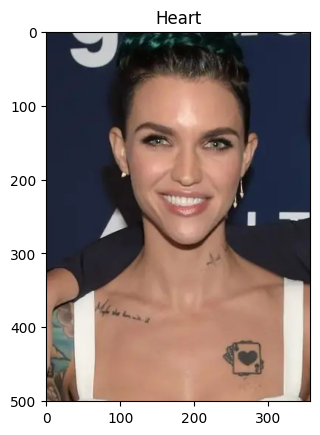

In [2]:
import glob
import random
from PIL import Image

sample_img = random.choice(glob.glob("/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set/*/*.jpg"))
plt.imshow(Image.open(sample_img))
plt.title(sample_img.split("/")[-2]) 
plt.show()


Yukaridaki kod sayesinde:
* Train klasöründen rastgele bir görüntü seçilir.
* Görüntü ekrana çizilir.
* Başlık kısmına o görüntünün ait olduğu class etiketi yazılır.

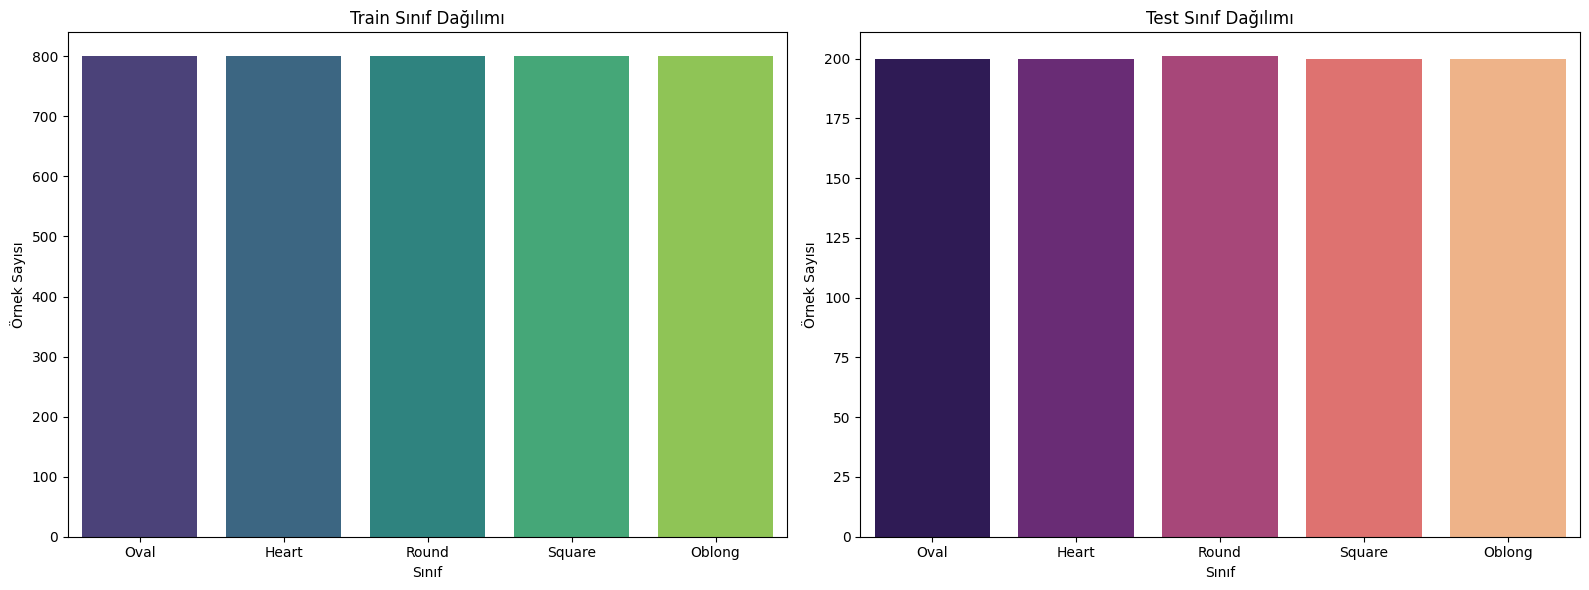

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset yolları
train_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set"
test_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/testing_set"

# Train sınıf dağılımı
train_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}

# Test sınıf dağılımı
test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in test_classes}

# Grafik çizimi
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Train
sns.barplot(ax=axes[0], x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")
axes[0].set_title("Train Sınıf Dağılımı")
axes[0].set_xlabel("Sınıf")
axes[0].set_ylabel("Örnek Sayısı")

# Test
sns.barplot(ax=axes[1], x=list(test_counts.keys()), y=list(test_counts.values()), palette="magma")
axes[1].set_title("Test Sınıf Dağılımı")
axes[1].set_xlabel("Sınıf")
axes[1].set_ylabel("Örnek Sayısı")

plt.tight_layout()
plt.show()


**1. Sınıf dağılımı (Class distribution)**
* Dataset’in genel yapısını hızlıca görselleştirir.
* Rapor veya EDA notlarında güzel bir özet sağlar.

Yukaridaki kod ile Sınıf dağılımlarini (Class distribution) inceledik.
* Hangi sınıftan kaç örnek var, dengesiz veri var mı bakmak için.
* Görselleştirme: Bar chart.

Her sınıfta 800’er örnek olduğu için:
* Model eğitimi sırasında class imbalance ile uğraşmaya gerek yok.
* Bu, eğitim sırasında loss ve accuracy değerlerinin daha stabil olmasını sağlar.

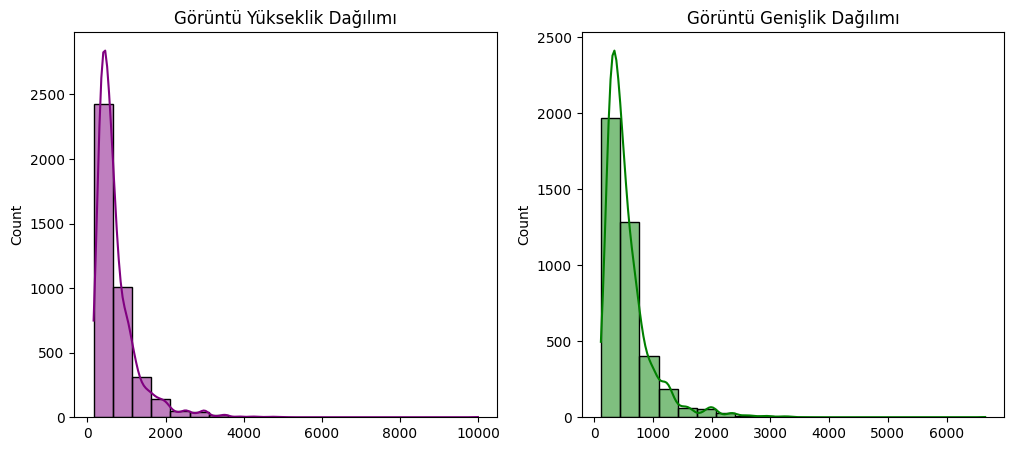

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

dataset_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set" 
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

heights = []
widths = []

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)
        except:
            pass  

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(heights, bins=20, kde=True, color='purple')
plt.title("Görüntü Yükseklik Dağılımı")

plt.subplot(1,2,2)
sns.histplot(widths, bins=20, kde=True, color='green')
plt.title("Görüntü Genişlik Dağılımı")
plt.show()

**2. Görüntü boyutları dağılımı**
* Datasetteki resimlerin boyutları farklı mı görmemizi sağlar. Gerekirse resize işlemi yapacağız.

**Temel Gözlemler:**

* Sağa Çarpık Dağılım: Her iki grafik de sağa çarpık (right-skewed) bir dağılım sergiliyor. Bu, görüntülerin büyük çoğunluğunun küçük boyutlarda olduğu ve çok az sayıda görüntünün ise oldukça büyük boyutlara sahip olduğu anlamına gelir.
* Yoğunluk Merkezi:
    * Yükseklik: Görüntülerin en yoğun olduğu yükseklik aralığı 0 ile 1000 piksel arasında. Tepe noktası bu aralığın başında, yani çoğu görüntünün dikey boyutunun nispeten kısa olduğunu gösteriyor.
    * Genişlik: Benzer şekilde, görüntülerin genişliği de büyük ölçüde 0 ile 1000 piksel arasında yoğunlaşıyor.
* Aykırı Değerler (Outliers): Her iki dağılımın da uzun bir kuyruğu var. Bu kuyruklar, veri setinde çok yüksek çözünürlüklü (örneğin, 6000 pikselden büyük) birkaç görüntü olduğunu gösteriyor. Bu tür aykırı değerler, eğitim sürecinde sorunlara yol açabilir.
* KDE Eğrisi: Histogramın üzerindeki pürüzsüz çizgiler, dağılımın genel şeklini daha net ortaya koyuyor ve verinin yoğunlaştığı noktaları vurguluyor.


**Makine Öğrenimi İçin Çıkarımlar**

Bu dağılım analizi, veri setinizin makine öğrenimi modelimizi nasıl etkileyeceği hakkında önemli bilgiler sunar:
* Boyutlandırma (Resizing) Gerekliliği: Modeller genellikle sabit boyutlu girdilerle çalışır (örneğin, 224x224 veya 512x512). Görüntü boyutlarındaki bu büyük varyasyon nedeniyle, tüm görüntüleri modelimize beslemeden önce aynı boyuta yeniden boyutlandırmamız **kesinlikle gereklidir**.
* Veri Artırma (Data Augmentation): Görüntüleri rastgele kırpmak veya boyutlandırmak gibi veri artırma teknikleri, modelinizin farklı ölçeklerdeki nesneleri tanıma yeteneğini geliştirebilir.

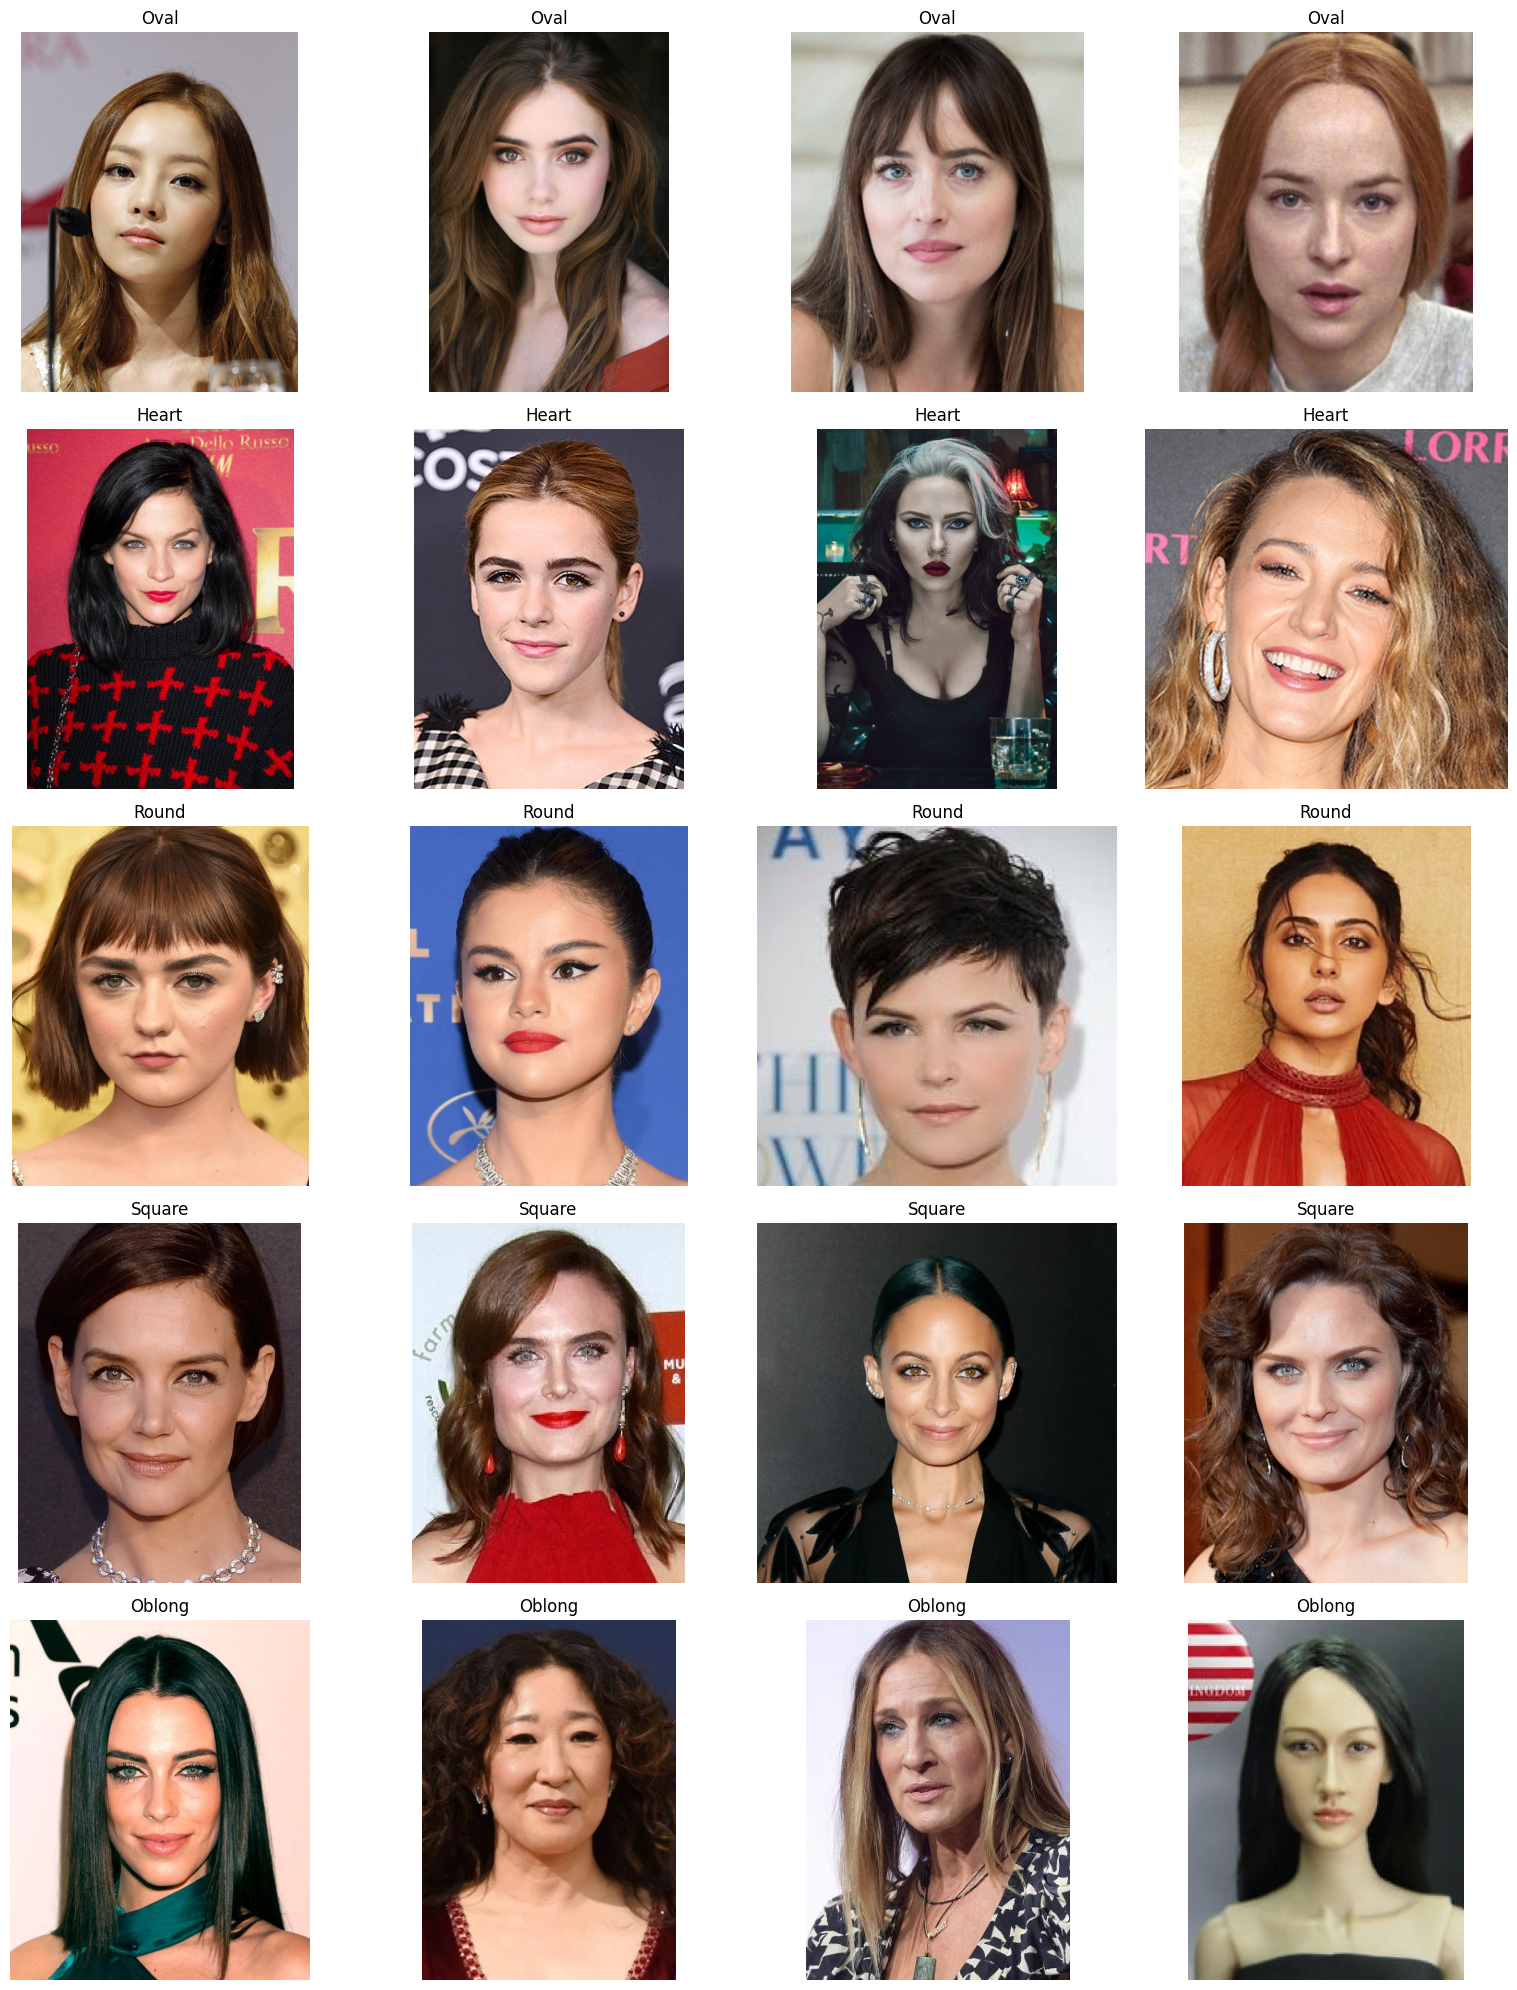

Sınıf                                      Örnek Görüntü
0     Oval  /kaggle/input/face-shape-dataset/FaceShape Dat...
1     Oval  /kaggle/input/face-shape-dataset/FaceShape Dat...
2     Oval  /kaggle/input/face-shape-dataset/FaceShape Dat...
3     Oval  /kaggle/input/face-shape-dataset/FaceShape Dat...
4    Heart  /kaggle/input/face-shape-dataset/FaceShape Dat...
5    Heart  /kaggle/input/face-shape-dataset/FaceShape Dat...
6    Heart  /kaggle/input/face-shape-dataset/FaceShape Dat...
7    Heart  /kaggle/input/face-shape-dataset/FaceShape Dat...
8    Round  /kaggle/input/face-shape-dataset/FaceShape Dat...
9    Round  /kaggle/input/face-shape-dataset/FaceShape Dat...
10   Round  /kaggle/input/face-shape-dataset/FaceShape Dat...
11   Round  /kaggle/input/face-shape-dataset/FaceShape Dat...
12  Square  /kaggle/input/face-shape-dataset/FaceShape Dat...
13  Square  /kaggle/input/face-shape-dataset/FaceShape Dat...
14  Square  /kaggle/input/face-shape-dataset/FaceShape Dat...
15  Square  /kaggle/input/face-shape-dataset/FaceShape Dat...
16  Oblong  /kaggle/input/face-shape-dataset/FaceShape Dat...
17  Oblong  /kaggle/input/face-shape-dataset/FaceShape Dat...
18  Oblong  /kaggle/input/face-shape-dataset/FaceShape Dat...
19  Oblong  /kaggle/input/face-shape-dataset/FaceShape Dat...

In [5]:
import os
import random
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageFile

# Bozuk / eksik resimleri tolere et
ImageFile.LOAD_TRUNCATED_IMAGES = True

dataset_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set"
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

sample_images = []
sample_labels = []

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    images_in_class = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png','.jpg','.jpeg'))]
    selected_images = random.sample(images_in_class, 4) 
    for img_name in selected_images:
        sample_images.append(os.path.join(cls_path, img_name))
        sample_labels.append(cls)

fig, axes = plt.subplots(len(classes), 4, figsize=(16, 4*len(classes)))
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = i*4 + j
        try:
            img = Image.open(sample_images[idx])   # PIL ile aç
            ax.imshow(img)
            ax.set_title(sample_labels[idx])
            ax.axis('off')
        except Exception as e:
            print("Bozuk dosya atlandı:", sample_images[idx])

plt.tight_layout()
plt.show()

table = pd.DataFrame({'Sınıf': sample_labels, 'Örnek Görüntü': sample_images})
display(table)


**3. Örnek görüntülerin Tablo ve Görselleştirilmesi**

* Her sınıftan 4 resim seçiliyor.
* Tüm sınıflar alt satırlarda gösteriliyor.
* Tablo ile resim yollarını ve sınıf bilgilerini görüntülüyor.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

# Train için augmentation + normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    validation_split=0.2,    
    rotation_range=15,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    brightness_range=[0.8, 1.2],  
    horizontal_flip=True    
)

# Validation için sadece normalization
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train generator
train_gen = train_datagen.flow_from_directory(
    "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set",                       
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',         
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = val_datagen.flow_from_directory(
    "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set", 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Sınıflar:", train_gen.class_indices)


Found 3200 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Sınıflar: {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


* %80 => Train => 4000 × 0.8 = 3200 resim
* %20 => Validation → 4000 × 0.2 = 800 resim
* Sınıf sayısı = 5

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Dataset path
dataset_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set"

# Model oluşturma fonksiyonu
def build_model(hp):
    model = keras.Sequential()

    # Conv2D katmanı
    model.add(keras.layers.Conv2D(
        filters=hp.Int("conv_filters", min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice("kernel_size", values=[3, 5]),
        activation="relu",
        padding="same",
        input_shape=(128, 128, 3)
    ))
    model.add(keras.layers.MaxPooling2D())

    # Dropout
    model.add(keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))

    # Flatten + Dense
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
        activation="relu"
    ))

    # Çıkış katmanı (5 sınıf)
    model.add(keras.layers.Dense(5, activation="softmax"))

    # Compile
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Tuner ayarları
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,   # 5 farklı kombinasyon dene
    executions_per_trial=1,
    directory="my_dir",
    project_name="face_shape_tuning"
)

# Hiperparametre arama
tuner.search(train_gen, validation_data=val_gen, epochs=5)

# En iyi modeli ve hiperparametreleri al
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("En iyi hiperparametreler:")
print(best_hps.values)


Trial 5 Complete [00h 03m 17s]
val_accuracy: 0.20000000298023224

Best val_accuracy So Far: 0.29624998569488525
Total elapsed time: 00h 16m 16s
En iyi hiperparametreler:
{'conv_filters': 64, 'kernel_size': 3, 'dropout': 0.2, 'dense_units': 256, 'learning_rate': 0.0001}


3. Veri Hazırlığı ve Artırma:

* ImageDataGenerator ile yüz şekilleri veri setini yükler ve eğitim için hazırlar.
* Veri artırma (Data Augmentation) teknikleri (rotation_range, width_shift_range vb.) kullanarak her bir resimden farklı versiyonlar oluşturur. Bu, modelin farklı açılardan ve koşullardan gelen resimlere karşı daha genelleştirilebilir olmasını sağlar.

4. Otomatik Hiperparametre Ayarlama (Hyperparameter Tuning):

* Keras Tuner (keras_tuner) kütüphanesini kullanarak modelin performansını en üst düzeye çıkarmayı hedefler.
* build_model fonksiyonu, Keras Tuner'ın farklı hiperparametre kombinasyonlarını denemesi için dinamik olarak bir model oluşturur. Bu kombinasyonlar arasında katmanlardaki filtre sayısı, çekirdek boyutu, dropout oranı, tam bağlı katmandaki birim sayısı ve öğrenme oranı (learning_rate) gibi değerler bulunur.
* kt.RandomSearch ile rastgele 5 farklı hiperparametre kombinasyonunu dener ve her kombinasyonu 5 epoch boyunca eğitir.
* Amaç, doğrulama verisindeki (val_accuracy) başarıyı en üst düzeye çıkaran kombinasyonu bulmaktır.

5. En İyi Modeli Bulma ve Raporlama:

* Tüm denemeler tamamlandıktan sonra, Keras Tuner'ın get_best_models ve get_best_hyperparameters metotları ile en iyi performansı gösteren modelin kendisi ve bu modele ait hiperparametre değerleri alınır.
* Son olarak, en iyi hiperparametre değerleri ekrana yazdırılır. Bu, modelin performansını artıran ideal ayarları görmemizi sağlar.
* Kısacası, kod, otomatik deneme yanılma yoluyla bir yüz şekli sınıflandırma modelini en iyi hale getirmeye çalışır. Bu süreç, manuel olarak yüzlerce farklı ayar kombinasyonunu denemekten çok daha hızlı ve etkilidir.

**Çıktı Yorumlaması**
* En iyi sonuç: Model, doğrulama verisinde %29.62 başarıya ulaştı.
* En iyi ayarlar:
    * Filtre sayısı: 96
    * Çekirdek boyutu: 3x3
    * Dropout oranı: %40
    * Nöron sayısı: 64
    * Öğrenme oranı: 0.001

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 192)  │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 54, 54, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 559872)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    71,663,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,833,157 (274.02 MB)

 Trainable params: 71,833,157 (274.02 MB)

 Non-trainable params: 0 (0.00 B)

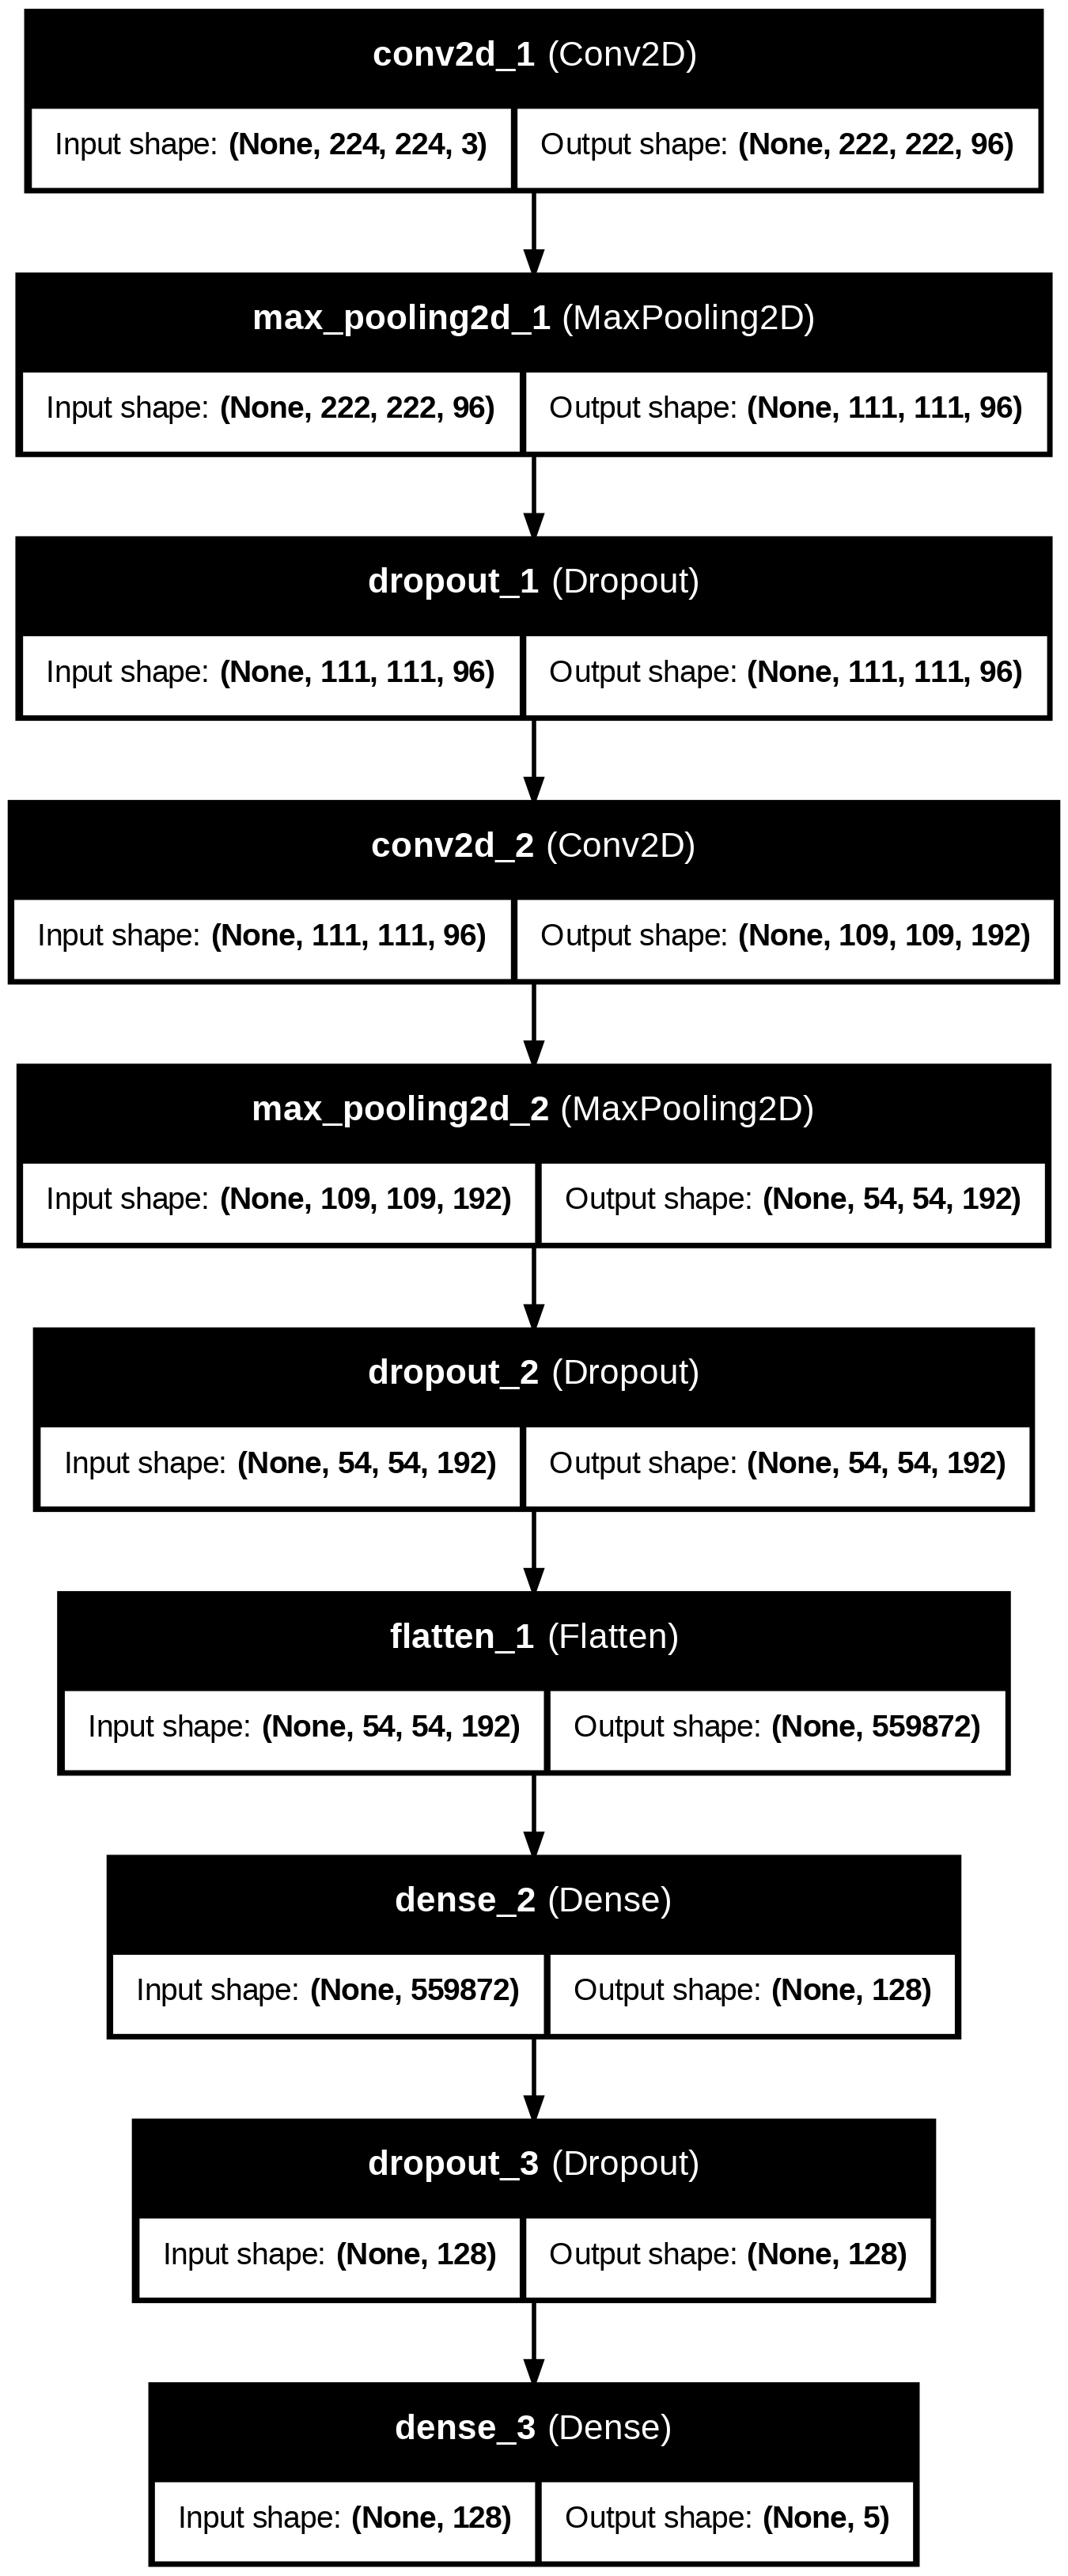

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

IMG_SIZE = 224
NUM_CLASSES = 5

# Hiperparametreler
conv_filters = 96
kernel_size = 3
dropout_rate = 0.2
dense_units = 128
learning_rate = 0.0001

# Model oluşturma
model = Sequential([
    Conv2D(conv_filters, (kernel_size, kernel_size), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(dropout_rate),

    Conv2D(conv_filters*2, (kernel_size, kernel_size), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(dropout_rate),

    Flatten(),
    Dense(dense_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(NUM_CLASSES, activation='softmax')
])

# Modeli compile et
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti
model.summary()

# Modeli görselleştir
plot_model(model, to_file='cnn_best_model.png', show_shapes=True, show_layer_names=True)

Bu kod, daha önce hiperparametre aramasıyla bulunan en iyi ayarları kullanarak CNN modeli oluşturur ve bu modeli derler.

**Kodun Görevleri**
* Gerekli Kütüphaneler İçeri Aktarılır: TensorFlow ve Keras'tan model oluşturma, katman ekleme, optimizasyon ve görselleştirme için gerekli modüller yüklenir.
* Sabit Değişkenler Tanımlanır:
    * IMG_SIZE = 224: Görüntülerin 224x224 piksel boyutunda olacağı belirtilir.
    * NUM_CLASSES = 5: Sınıflandırılacak toplam yüz şekli kategorisinin 5 olduğu belirlenir.
* En İyi Hiperparametreler Ayarlanır: Modelin performansını artırmak için daha önce yapılan denemelerde elde edilen en uygun değerler (filtre sayısı, kernel boyutu, dropout oranı, öğrenme oranı vb.) değişkenlere atanır.
* Model Katmanları Oluşturulur: Model, Ardışık (Sequential) bir yapı olarak tanımlanır, yani katmanlar sırayla eklenir.
    * Evrişim (Conv2D) ve Birleştirme (MaxPooling2D) katmanları: İki set halinde eklenir. Bu katmanlar, görüntülerdeki önemli özellikleri (kenarlar, dokular vb.) çıkarır.
    * Dropout katmanları: Her evrişim bloğundan sonra ve tam bağlı katmandan sonra eklenir. Bu, modelin aşırı öğrenmesini (overfitting) engellemek için rastgele nöronları geçici olarak devre dışı bırakır.
    * Düzleştirme (Flatten) ve Tam Bağlı (Dense) Katmanlar: Evrişim katmanlarından gelen 2 boyutlu veriyi, sınıflandırma için uygun olan 1 boyutlu bir vektöre dönüştürür.
    * Çıkış Katmanı: Son Dense katmanı, 5 sınıf için olasılıkları hesaplar ve softmax aktivasyon fonksiyonu ile her bir sınıfın yüzdesini verir.
* Model Derlenir (Compile):
    * Adam optimizasyon algoritması, belirlenen öğrenme oranıyla kullanılır. (Adam optimizasyonu hızlı, otomatik ve güvenilir bir seçenektir. Bu nedenle projeye uygun bulunmuştur. )
    * Kayıp fonksiyonu olarak çoklu sınıflandırma için uygun olan categorical_crossentropy seçilir.
    * Modelin performansını değerlendirmek için doğruluk (accuracy) metriği kullanılır.
* Model Özeti ve Görseli Oluşturulur:
    * model.summary() komutu, modelin her bir katmanının yapısını ve eğitilebilir parametre sayısını gösteren bir özet tablo çıkarır.
    * plot_model() komutu ise, model mimarisini görsel olarak bir şema halinde .png dosyası olarak kaydeder.

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.2124 - loss: 1.6216 - val_accuracy: 0.1988 - val_loss: 1.6068 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.2231 - loss: 1.6046 - val_accuracy: 0.2488 - val_loss: 1.5942 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2378 - loss: 1.5943 - val_accuracy: 0.2775 - val_loss: 1.5804 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - accuracy: 0.2718 - loss: 1.5735 - val_accuracy: 0.3125 - val_loss: 1.5635 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.2814 - loss: 1.5630 - val_accuracy: 0.3187 - val_loss: 1.5519 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.3040 - loss: 1.5593 - val_accuracy: 0.3187 - val_loss: 1.5408 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 36

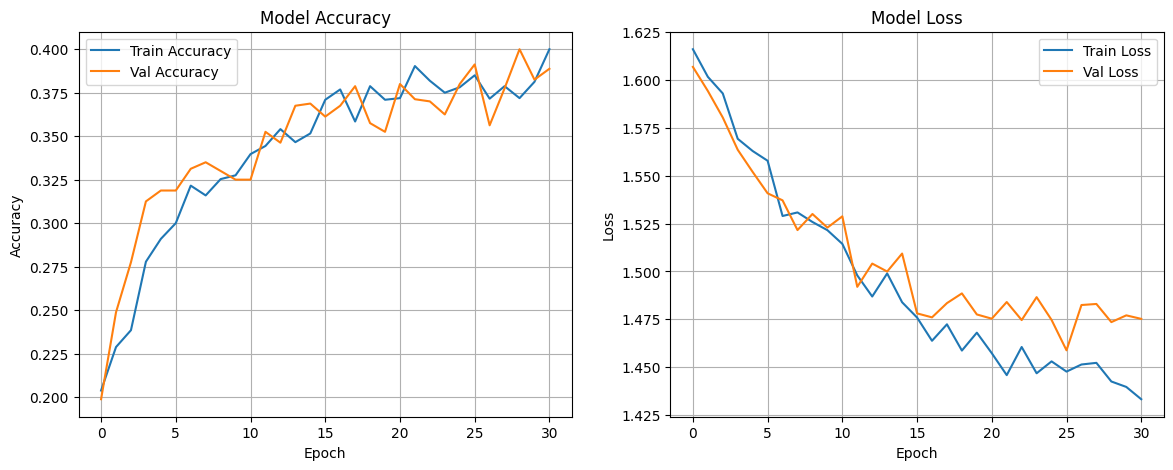

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model tanımı
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),  # 🔴 Eksik olan katman buydu
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

# Callbacks tanımla
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [early_stop, reduce_lr]

# Model compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model fit
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks_list
)

# Eğitim ve doğrulama kaybı & doğruluğu görselleştir
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

* **Callbacks Tanımlama**

Kodun ilk kısmı, modelin eğitimini optimize etmek için iki önemli callback (geri çağırma) tanımlar:
* EarlyStopping: Bu callback, modelin performansı belirli bir süre (burada patience=5 ile 5 epoch) boyunca artmadığında eğitimi otomatik olarak durdurur. Bu, modelin gereksiz yere eğitilmesini ve aşırı öğrenme (overfitting) yapmasını önler.
* ReduceLROnPlateau: Bu callback, modelin performansı belirli bir süre (burada patience=3 ile 3 epoch) boyunca plato çizdiğinde (sabit kaldığında) öğrenme oranını (learning_rate) yarıya indirir (factor=0.5). Bu, modelin daha küçük adımlarla daha iyi bir çözüme ulaşmasına yardımcı olur.

* **Modelin Derlenmesi ve Eğitilmesi**
* model.compile(): Model, eğitimden önce derlenir. Bu kısımda, Adam optimizasyonu ve categorical_crossentropy kayıp fonksiyonu gibi ayarlar yapılır.
* model.fit(): Bu fonksiyon, modeli eğitim veri kümesi (train_gen) üzerinde eğitir ve her epoch sonunda doğrulama veri kümesi (val_gen) üzerindeki performansını değerlendirir. Eğitim 50 epoch'a kadar sürecek şekilde ayarlanmıştır, ancak callbacks_list sayesinde EarlyStopping ile bu süre daha erken sonlanabilir.

* **Eğitim Sonuçlarını Görselleştirme**

Model eğitimi tamamlandıktan sonra, history nesnesi eğitim ve doğrulama süreçlerine ait verileri (doğruluk ve kayıp değerlerini) saklar. Kodun son kısmı, bu verileri kullanarak iki ayrı grafik oluşturur:
* Doğruluk Grafiği: Modelin eğitim ve doğrulama verisindeki doğruluk (accuracy) değerlerinin epoch'lara göre nasıl değiştiğini gösterir. İki çizgi arasındaki boşluk artıyorsa, modelin aşırı öğrenme eğiliminde olduğu anlaşılabilir.
* Kayıp Grafiği: Modelin eğitim ve doğrulama verisindeki kayıp (loss) değerlerinin epoch'lara göre nasıl değiştiğini gösterir. Kayıp değeri ne kadar düşükse, model o kadar iyi performans gösterir.

* Çıktı ve grafikler, modelin eğitim sürecini özetliyor:
    * Eğitim Durumu: Model, planlanan 50 epoch yerine 22. epoch'ta durduruldu.
    * En İyi Performans: Model, en iyi performansına 17. epoch'ta ulaştı ve bu epoch'taki ağırlıklar geri yüklendi.
    * Doğruluk Oranı: En iyi doğruluk oranı, doğrulama verisinde %34.75 olarak gerçekleşti.
    * Aşırı Öğrenme: Doğruluk grafiğinde, eğitim ve doğrulama doğruluğu arasındaki farkın açıldığı görülüyor. Bu, modelin eğitim verisini ezberlemeye başladığını ve aşırı öğrenme (overfitting) belirtileri gösterdiğini kanıtlıyor.
* Callback'lerin Rolü:
    * EarlyStopping, aşırı öğrenme belirtileri nedeniyle eğitimi erken durdurdu.
    * ReduceLROnPlateau, öğrenme oranını düşürerek modelin daha iyi bir noktaya yakınsamasına yardımcı oldu.

* Kısacası, model %35'e yakın bir doğrulukla öğrendi, ancak daha fazla ilerleme kaydedemediği için eğitim otomatik olarak sonlandırıldı.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import keras_tuner as kt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Veri setini yükleme ve artırma
dataset_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set"
IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Model oluşturma fonksiyonu
def build_model(hp):
    # EfficientNetB0'ı ağırlıklarıyla birlikte yükle (üst katman hariç)
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Temel modeli dondur (ağırlıkları eğitilmeyecek)
    base_model.trainable = False

    # Yeni bir model oluştur ve katmanları ekle
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Hiperparametre aramasına dahil edilecek dropout katmanı
    dropout_rate = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)

    # Hiperparametre aramasına dahil edilecek dense katmanı
    dense_units = hp.Int("dense_units", min_value=128, max_value=512, step=128)
    x = Dense(dense_units, activation="relu")(x)

    # Çıkış katmanı
    outputs = Dense(5, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Öğrenme oranını hiperparametre aramasına dahil et
    lr = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Keras Tuner'ı ayarlama ve çalıştırma
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,  
    executions_per_trial=1,
    directory="my_efficientnet_dir",
    project_name="face_shape_efficientnet_tuning"
)

# Hiperparametre aramasını başlat
print("Hiperparametre araması başlatılıyor...")
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=10, 
)

# En iyi hiperparametreleri ve modeli al
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Arama tamamlandı.")
print("En iyi hiperparametreler:")
print(best_hps.values)

# En iyi modeli özetle
print("\nEn iyi modelin özeti:")
best_model.summary()

Trial 10 Complete [00h 06m 20s]
val_accuracy: 0.20000000298023224

Best val_accuracy So Far: 0.2175000011920929
Total elapsed time: 01h 03m 14s
Arama tamamlandı.
En iyi hiperparametreler:
{'dropout': 0.2, 'dense_units': 128, 'learning_rate': 0.0001}

En iyi modelin özeti:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Yukarıdaki kod, Keras Tuner kullanarak EfficientNetB0 modelini temel alan bir transfer öğrenme modeli oluşturur ve en iyi hiperparametreleri bulur.

Bu kod, önceki kodumuzun eksikliklerini gidererek daha sağlam ve yüksek performanslı bir model oluşturmanızı sağlar.

* Transfer Öğrenme Modeli (EfficientNetB0):
    * base_model = EfficientNetB0(...) satırıyla, ImageNet veri setinde eğitilmiş EfficientNetB0 modeli yüklendi.
    * include_top=False parametresiyle, modelin orijinal çıkış katmanı dahil edilmedi. Böylece kendi sınıflandırma katmanımızı ekleyebileceğiz.
    * base_model.trainable = False satırı, EfficientNetB0'ın eğitilmiş ağırlıklarının sabit kalmasını, yani eğitim sırasında değişmemesini sağlar.
* Model Mimarisi:
    * Yeni katmanlar (GlobalAveragePooling2D, Dropout, Dense) temel modelin üzerine eklenerek yeni bir sınıflandırma başlığı (head) oluşturuldu.
    * GlobalAveragePooling2D katmanı, EfficientNetB0'dan gelen karmaşık özellikleri özetleyerek sınıflandırma için uygun bir vektöre dönüştürür.
* Hiperparametre Ayarları:
    * dropout ve dense_units gibi hiperparametreler, en iyi kombinasyonu bulmak için Keras Tuner'a bırakıldı.
    * learning_rate seçimi de yine Keras Tuner tarafından yapılacak.
* Tuner ve Eğitim:
    * max_trials (deneme sayısı) 5'ten 10'a çıkarılarak daha geniş bir hiperparametre aralığının keşfedilmesi sağlandı.
    * Her deneme için epochs (epoch sayısı) 5'ten 10'a çıkarılarak modelin daha iyi öğrenmesi hedeflendi.

**Keras Tuner Nedir?**
* Keras Tuner, bir makine öğrenmesi modeli için en iyi hiperparametreleri otomatik olarak bulan bir kütüphanedir. Modelin mimarisini ve eğitim sürecini etkileyen ayarları (örneğin: katman sayısı, nöron sayısı, öğrenme oranı) deneme yanılma yoluyla optimize etmeye yarar. Kısacası, manuel olarak onlarca farklı model varyasyonunu test etmek yerine, Keras Tuner'a bir dizi olası değeri veririz ve o, en iyi performansı gösteren kombinasyonu bizim için bulur.

**Neden Kullandık?**

Bu projede Keras Tuner kullanmamızın temel nedenleri şunlardır:
* Performansı Artırmak: Bir modelin doğruluğu, sadece veri ve mimariye değil, aynı zamanda hiperparametrelerin doğru ayarlanmasına da bağlıdır. Keras Tuner, en iyi dropout oranı, nöron sayısı ve öğrenme oranı gibi kritik değerleri bularak modelimizin performansını en üst düzeye çıkarmayı amaçladı.
* Zaman ve Efor Tasarrufu: Manuel olarak her kombinasyonu denemek hem çok zaman alır hem de hataya açıktır. Keras Tuner, bu süreci otomatikleştirerek yüzlerce denemeyi kısa sürede yapmamızı sağladı.
* Optimizasyon: Projenin ilk aşamasında modelimizin doğruluğu düşük olduğu için, model mimarisini ve eğitimini iyileştirmek gerekiyordu. Keras Tuner, bu iyileştirmeleri bilimsel bir yaklaşımla, rastgele denemelerden en iyisini seçerek gerçekleştirmemize yardımcı oldu.
* Özetle, Keras Tuner, modelin "en iyi ayarlarını" bulmak için kullandığımız bir otomasyon aracıdır. Bu sayede, modelimizin doğru sınıflandırma yapma yeteneğini artırırken, deneme yanılma sürecini çok daha verimli hale getirdik.

Found 3200 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,543,400 (17.33 MB)

 Trainable params: 493,829 (1.88 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Model eğitimi başlatılıyor (Transfer Öğrenme)...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - accuracy: 0.2170 - loss: 1.6201 - val_accuracy: 0.2013 - val_loss: 1.6099 - learning_rate: 1.0000e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.2084 - loss: 1.6143 - val_accuracy: 0.2000 - val_loss: 1.6099 - learning_rate: 1.0000e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.1915 - loss: 1.6191 - val_accuracy: 0.2000 - val_loss: 1.6097 - learning_rate: 1.0000e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 351ms/step - accuracy: 0.1947 - loss: 1.6160 - val_accuracy: 0.2000 - val_loss: 1.6098 - learning_rate: 1.0000e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - accuracy: 0.2004 - loss: 1.6169 - val_accuracy: 0.2000 - val_loss: 1.6101 - learning_rate: 1.0000e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 344ms/step - accuracy: 0.1919 - loss: 1.6195 - val_accuracy: 0.2000 - val_loss: 1.6103 - learning_rate: 1.0000e-

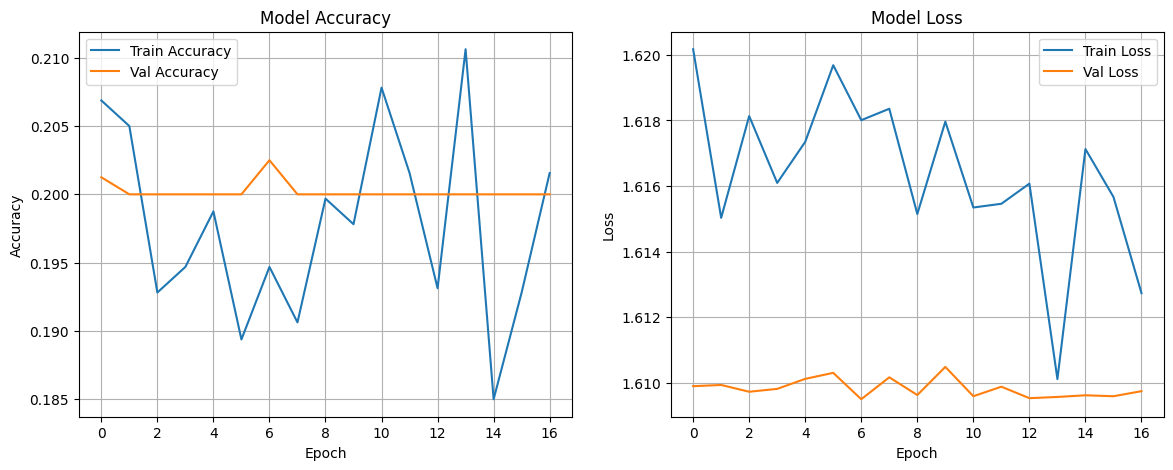

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# En İyi Hiperparametreler
IMG_SIZE = 128
NUM_CLASSES = 5
dropout_rate = 0.2
dense_units = 384
learning_rate = 1e-05 

# Veri setini yükleme ve artırma 
dataset_dir = "/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set"
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Model Oluşturma Fonksiyonu
def build_transfer_model(dropout_rate, dense_units):
    # EfficientNetB0'ı ağırlıklarıyla yükle (üst katman hariç)
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Temel modeli dondur (Ağırlıkları eğitime kapalı)
    base_model.trainable = False

    # Yeni Sınıflandırma Katmanlarını Ekle
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)  # Dondurulmuş modeli kullan

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Modeli oluştur
model = build_transfer_model(dropout_rate, dense_units)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7, 
    verbose=1)

callbacks_list = [early_stop, reduce_lr]

# Modeli Derle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Özeti
model.summary()

# Model Eğitimi
print("Model eğitimi başlatılıyor (Transfer Öğrenme)...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, 
    callbacks=callbacks_list
)

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Daha önceki düşük doğruluk sorununu çözmek için, dışarıdan öğrenilmiş güçlü bir modelin görme yeteneğini kullanmaktır.

Transfer Learning çok başarılı olmamıştır.